In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from healpy import projview
from icecube_tools.utils.data import RealEvents, SimEvents
from icecube_tools.point_source_analysis.point_source_analysis import MapScan, MapScanTSDistribution
import h5py
from scipy.stats import ncx2, chi2

## Idea to parallelise in a sensible fashion

Set npix/nside to the desired angular resolution and generate sources. Split sources into reasonable length parts, e.g. 1000 sources, meaning `MapScan().test_ra = MapScan().test_ra[n*1000:(n+1)*1000]`. Then write config with distinct name. Repeat until all sources are in mentioned in a config.

Read in configs in parallel processes, calculate, write output again with same distinct identifier.

Make script reading in all result files.

In [11]:
events = RealEvents.from_event_files()

In [12]:
scan = MapScan("config.yaml", events, "skymap_ngc_restricted_updated_dec.hdf5")

In [13]:
events.periods

['IC40', 'IC59', 'IC79', 'IC86_I', 'IC86_II']

In [14]:
r = np.deg2rad(np.linspace(38, 42, num=11))
d = np.deg2rad(np.linspace(-2, 2, num=11))
rr, dd = np.meshgrid(r, d)
rr = rr.flatten()
dd = dd.flatten()
print(rr.size)

121


In [15]:
scan.ra_test = rr
scan.dec_test = dd
scan.generate_sources(nside=False)
scan.ts.shape

(121,)

In [16]:
scan.perform_scan(show_progress=True)

  0%|          | 0/121 [00:00<?, ?it/s]/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
100%|██████████| 121/121 [02:16<00:00,  1.13s/it]


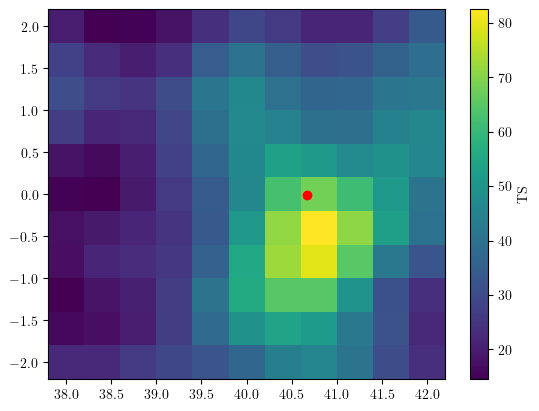

In [17]:
fig, ax = plt.subplots()
pcol = ax.pcolormesh(np.rad2deg(r), np.rad2deg(d), scan.ts.reshape((11, 11)), shading="nearest")
fig.colorbar(pcol, ax=ax, label='TS')
ax.scatter(40.6696215289200, -00.0132943583900, c="red")

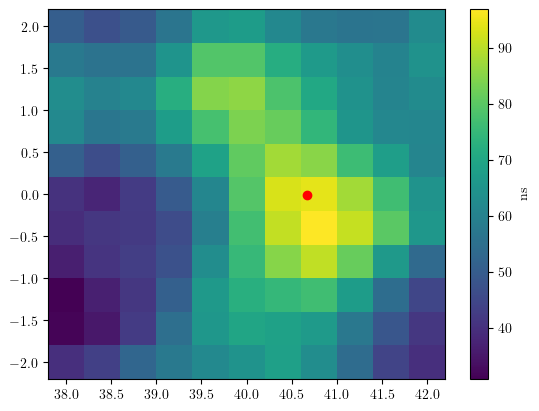

In [9]:
fig, ax = plt.subplots()
pcol = ax.pcolormesh(np.rad2deg(r), np.rad2deg(d), scan.ns.reshape((11, 11)), shading="nearest")
fig.colorbar(pcol, ax=ax, label='ns')
ax.scatter(40.6696215289200, -00.0132943583900, c="red")

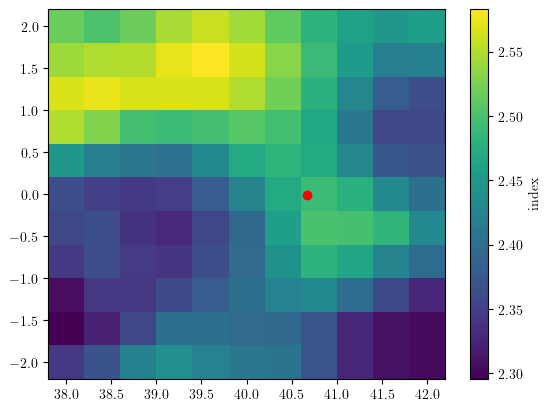

In [10]:
fig, ax = plt.subplots()
pcol = ax.pcolormesh(np.rad2deg(r), np.rad2deg(d), scan.index.reshape((11, 11)), shading="nearest")
fig.colorbar(pcol, ax=ax, label='index')
ax.scatter(40.6696215289200, -00.0132943583900, c="red")

In [19]:
scan.ts.max()


82.44414533528521

## Create TS distribution
TS values themselves are not calibrated, we need to "simulate" (i.e. for a large enough data set shuffle the RAs to wash out any source associations) lots of events, fit again a source and find the TS. From the number of simulated data sets with TS larger than the one from the un-shuffled data we obtain the local p-value.

Since the declination-dependency is given by the declination dependency of the effective area, it is sufficient to create TS distributions only once for each aeff's declination bin.

In [3]:
ts_dist = MapScanTSDistribution("config.yaml", events, "ts_dist.hdf5")

In [4]:
ts_dist.ra_test = np.array([np.pi])
ts_dist.dec_test = np.array([np.deg2rad(-0.3)])
ts_dist.ntrials=1000

In [5]:
ts_dist.generate_sources(nside=False)

In [6]:
ts_dist.ts.shape

(1000,)

In [7]:
ts_dist.perform_scan(show_progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
100%|██████████| 1000/1000 [18:48<00:00,  1.13s/it]


In [8]:
ts_copy = ts_dist.ts.copy()

In [9]:
ts_copy.sort()

(13.290580162523398, -6.904697572974882, 2.3093010858241234)


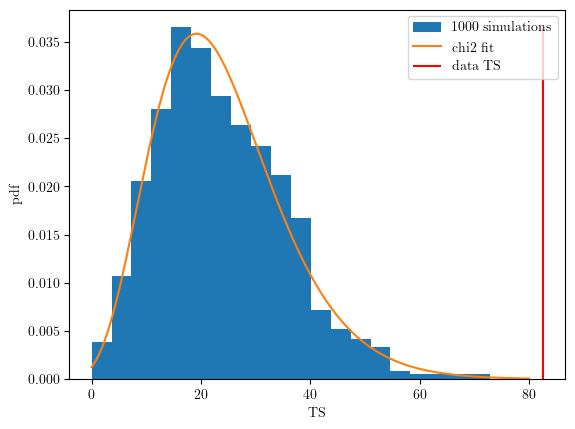

In [23]:
n, bins, patches = plt.hist(ts_copy, bins=20, density=True, label="1000 simulations")
pars = chi2.fit(ts_copy)
x = np.linspace(0, 80, num=1000)
plt.plot(x, chi2(*pars).pdf(x), label="chi2 fit")
plt.vlines(scan.ts.max(), 0, n.max(), label="data TS", color='red')
plt.xlabel("TS")
plt.ylabel("pdf")
plt.legend()
print(pars)
plt.savefig("ts_dist_ngc.png", dpi=150)